In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [2]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)
def read_csv_luk(paht): #../../data/archive/luk_price_m60.csv
    dataset = pd.read_csv(paht) 
#     '<OPEN>', '<HIGH>', '<LOW>', '<VOL>'
    dataset = dataset.drop(['<TICKER>', '<PER>', '<TIME>',  ],axis=1)
    # dataset['<TIME>'].to_datetime(format='%d%m%Y')
#     dataset.index = dataset['<DATE>'].astype(str) + dataset['<TIME>'].astype(str).apply(lambda i: i[:-4])
    dataset.index = dataset['<DATE>'].astype(str) + '18'
    dataset.drop(['<DATE>'], axis=1, inplace=True)
    dataset.index = pd.to_datetime(dataset.index, format='%Y%m%d%H')
    return dataset

dataset = read_csv_luk('./data/luk [Price]-d.txt')
# dataset.head()

In [3]:
dataset.tail()

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
<DATE>,,,,,
2018-12-24 18:00:00,4900.0,4966.0,4842.5,4909.0,623396.0
2018-12-25 18:00:00,4841.0,4842.5,4744.5,4810.0,269077.0
2018-12-26 18:00:00,4829.0,4859.0,4803.0,4829.5,182587.0
2018-12-27 18:00:00,4901.0,4925.5,4858.0,4884.0,491804.0
2018-12-28 18:00:00,4911.0,5009.5,4901.5,4955.5,662664.0


In [4]:
plotly_df(dataset, title = "CLOSE")

In [5]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [6]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
        
#     data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
#     data['is_weekend'] = data.weekday.isin([5,6])*1

#     # считаем средние только по тренировочной части, чтобы избежать лика
    data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
    data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

#     # выкидываем закодированные средними признаки 
    data.drop(["hour", "weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True )

#     # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]
    
    return X_train, X_test, y_train, y_test

In [7]:
from sklearn.linear_model import LinearRegression

In [8]:
 X_train, X_test, y_train, y_test = prepareData(dataset['<CLOSE>'], test_size=0.2, lag_start=1, lag_end=16)
lr = LinearRegression()
# X_train.head()
# y_train.head()

In [9]:
%%time
lr.fit(X_train, y_train)

Wall time: 10 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [10]:
# dataset_test = read_csv_luk('../../data/archive/luk_price_m60_test.csv')

In [11]:
#  X_train, X_test, y_train, y_test = prepareData(dataset_test['<CLOSE>'], test_size=9, lag_start=8, lag_end=32)

In [12]:
prediction = lr.predict(X_test)

prediction_pd = pd.DataFrame(prediction)

# prediction_pd.index = X_test.index
# prediction_pd.tail()
# X_test prediction_pd.index =
prediction_pd.index = dataset.index[-len(prediction_pd.index):]
# prediction_pd.head()
prediction_pd.tail()
# plotly_df(prediction_pd)



,0
<DATE>,
2018-12-24 18:00:00,4936.395606
2018-12-25 18:00:00,4895.384065
2018-12-26 18:00:00,4805.539665
2018-12-27 18:00:00,4823.552055
2018-12-28 18:00:00,4888.041102


In [13]:
plotly_df(prediction_pd)

In [14]:
plotly_df(pd.DataFrame(y_test.values))

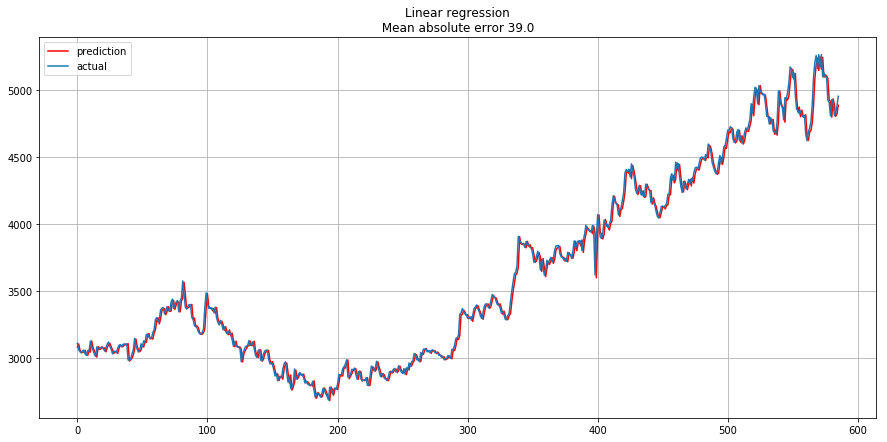

In [15]:
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} ".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

In [16]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [17]:
%%time
performTimeSeriesCV(X_train, y_train, 5, lr, mean_absolute_error)

Size train set: (2405, 17)
Size of each fold: 481

Splitting the first 2 chunks at 1/2
Size of train + test: (962, 17)

Splitting the first 3 chunks at 2/3
Size of train + test: (1443, 17)

Splitting the first 4 chunks at 3/4
Size of train + test: (1924, 17)

Splitting the first 5 chunks at 4/5
Size of train + test: (2405, 17)
Wall time: 76.1 ms


25.931497612984117

## 